In [4]:
import os
import glob

#data and math
import math
from math import e
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import datetime as dt
import geopy.distance
import uncertainties
from uncertainties import ufloat
from uncertainties.umath import *

#seawater property calculations
import seawater as sw
import gsw

#plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm #colormap
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

%matplotlib inline
import seaborn as sns
import cmocean as cmo

In [5]:
#import CSV file dCo_data_2-4-20.csv
df_data = pd.read_csv('C:/Users/Becca/Desktop/JP/GP15/ODV_2-4-20/dCo_data_5-20-2021_molarity_updated.csv')
df_data = df_data.dropna(subset = ['dCo [pM]'])
df_data = df_data.sort_values(['Station', 'DEPTH [m]'])
df_data = df_data.reset_index()

print(df_data.keys())

Index(['index', 'Unnamed: 0', 'Cruise', 'Station', 'Latitude', 'Longitude',
       'Sample #', 'Date Sampled', 'DEPTH [m]', 'Stn-depth', 'dCo [pM]',
       'LdCo [pM]', 'dZn [nmol/kg]', 'CTDPRS [dbar]', 'CTDTMP',
       'CTDOXY [umol/kg]', 'CTDFLUOR', 'CTDXMISS', 'CTDSAL', 'Salinity',
       'Silicate [umol/kg]', 'Phosphate [umol/kg]', 'Nitrate [umol/kg]',
       'Nitrite [umol/kg]', 'Density', 'dZn [nM]', 'Silicate [uM]',
       'Phosphate [uM]', 'Nitrate [uM]', 'Nitrite [uM]', 'Sigma0 [kg/m3]'],
      dtype='object')


In [6]:
#import GLODAP Pacific data
#downloaded from https://www.glodap.info/index.php/merged-and-adjusted-data-product-v2-2019/
df_GLODAP = pd.read_csv('C:/Users/Becca/Desktop/JP/GP15/GLODAP/GLODAPv2.2019_Pacific_Ocean.csv')

#drop data outside of certain lat/long range
lat_max = 60
lat_min = -25
long_max = -145
long_min = -160
df_GLODAP = df_GLODAP[df_GLODAP['latitude']<lat_max]
df_GLODAP = df_GLODAP[df_GLODAP['latitude']>lat_min]
df_GLODAP = df_GLODAP[df_GLODAP['longitude']<long_max]
df_GLODAP = df_GLODAP[df_GLODAP['longitude']>long_min]

#drop all data where c14f (C14 quality assurance flag) and aouf (AOU quality assurance flag) does not equal 2
good_flag = 2
df_C14 = df_GLODAP[df_GLODAP['c14f']==good_flag]
df_C14 = df_C14[df_C14['aouf']==good_flag]
df_C14 = df_C14.reset_index()
df_C14

,index,cruise,station,cast,year,month,day,hour,minute,latitude,...,toc,tocf,doc,docf,don,donf,tdn,tdnf,chla,chlaf
0,55555,268.0,204.0,6.0,1973.0,9.0,5.0,0.0,0.0,31.3780,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
1,55557,268.0,204.0,6.0,1973.0,9.0,5.0,0.0,0.0,31.3780,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
2,55562,268.0,204.0,6.0,1973.0,9.0,5.0,0.0,0.0,31.3780,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
3,55566,268.0,204.0,6.0,1973.0,9.0,5.0,0.0,0.0,31.3780,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
4,55569,268.0,204.0,7.0,1973.0,9.0,5.0,0.0,0.0,31.3780,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3392,393198,1044.0,196.0,2.0,2015.0,6.0,20.0,22.0,34.0,54.9505,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
3393,393199,1044.0,196.0,2.0,2015.0,6.0,20.0,22.0,34.0,54.9505,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
3394,393200,1044.0,196.0,2.0,2015.0,6.0,20.0,22.0,34.0,54.9505,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
3395,393201,1044.0,196.0,2.0,2015.0,6.0,20.0,22.0,34.0,54.9505,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0


In [7]:
#for each point from the GEOTRACES dataset with coordinates (Long, Lat), find the closest GLODAP point with geopy.distance 
        # then find the closest depth.
#*** This takes a long time to run! ***

#define point variables
#P1 is GEOTRACES point
x1 = 'Longitude'
y1 = 'Latitude'
z1 = 'DEPTH [m]'
#P2 is GLODAP point
x2 = 'longitude'
y2 = 'latitude'
z2 = 'depth'

#iterate over rows with iterrows()
GLODAP_index_column = []
hypot_distance_column = []
xy_distance_column = []
z_distance_column = []
for index, row in df_data.head(n=715).iterrows():
    #Specify GEOTRACES point using column names
    GP15_point = (row[y1], row[x1])
    Z1 = row[z1]
    print(index, row['Station'], GP15_point)
    hypot_distance_list = []
    xy_distance_list = []
    z_distance_list= []
    #calculate lat long distance to all GLODAP data that are within a range of the original point's depth and find the minimum 
        #distance datapoint
    for index, row in df_C14.head(n=3397).iterrows():
        GLODAP_point = (row[y2], row[x2])
        Z2 = row[z2]
        z_distance = abs(Z1 - Z2)
        if z_distance <= 200:
            xydistance_km = (geopy.distance.distance(GP15_point, GLODAP_point).km)
            xydistance_m = (xydistance_km * 1000)
            hypot_distance = ((xydistance_m)**2 + (z_distance)**2)**0.5
            hypot_distance_list.append(hypot_distance)
            xy_distance_list.append(xydistance_km)
            z_distance_list.append(z_distance)
        else: 
            NaN_key = 999999999
            hypot_distance_list.append(NaN_key)
            xy_distance_list.append(NaN_key)
            z_distance_list.append(NaN_key)
    min_distance = min(hypot_distance_list)
    #Add the minimum distance to an overall list
    min_distance_index = hypot_distance_list.index(min_distance) 
    min_xy_distance = xy_distance_list[min_distance_index]
    min_z_distance = z_distance_list[min_distance_index]
    print("\t", min_distance, min_distance_index, min_xy_distance, min_z_distance)
    GLODAP_index_column.append(min_distance_index)
    hypot_distance_column.append(min_distance)
    xy_distance_column.append(min_xy_distance)
    z_distance_column.append(min_z_distance)
    
print(GLODAP_index_column)

0 1.0 (56.094, -156.961)
	 194183.20486056665 956 194.18320486056666 0.0
1 1.0 (56.094, -156.961)
	 194183.20569483034 956 194.18320486056666 18.0
2 1.0 (56.094, -156.961)
	 194183.20687927882 956 194.18320486056666 28.0
3 1.0 (56.094, -156.961)
	 194183.20857870486 956 194.18320486056666 38.0
4 1.0 (56.094, -156.961)
	 194183.21079310845 956 194.18320486056666 48.0
5 1.0 (56.094, -156.961)
	 194183.20783713713 957 194.18320486056666 34.0
6 1.0 (56.094, -156.961)
	 194183.2057901012 957 194.18320486056666 19.0
7 2.0 (55.59477, -156.3461)
	 175438.50739345435 931 175.43850739345436 0.0
8 2.0 (55.59477, -156.3461)
	 175438.50773830453 932 175.43850739345436 11.0
9 2.0 (55.59477, -156.3461)
	 175438.50757585443 933 175.43850739345436 8.0
10 2.0 (55.59477, -156.3461)
	 175438.50757585443 935 175.43850739345436 8.0
11 2.0 (55.59477, -156.3461)
	 175438.50753310442 937 175.43850739345436 7.0
12 2.0 (55.59477, -156.3461)
	 175438.50757585443 938 175.43850739345436 8.0
13 2.0 (55.59477, -156.3

	 55598.396973573035 1664 55.5983913529071 25.0
106 7.0 (49.49992, -152.0)
	 55598.3933763469 1664 55.5983913529071 15.0
107 7.0 (49.49992, -152.0)
	 55598.391577733746 1664 55.5983913529071 5.0
108 7.0 (49.49992, -152.0)
	 55598.3939519031 1666 55.5983913529071 17.0
109 7.0 (49.49992, -152.0)
	 55598.396110238784 1667 55.5983913529071 23.0
110 7.0 (49.49992, -152.0)
	 55598.39531884904 1670 55.5983913529071 21.0
111 7.0 (49.49992, -152.0)
	 55598.391577733746 1672 55.5983913529071 5.0
112 7.0 (49.49992, -152.0)
	 55598.391928463316 1674 55.5983913529071 8.0
113 7.0 (49.49992, -152.0)
	 55598.615855352145 1675 55.5983913529071 158.0
114 8.0 (47.00001, -151.9999)
	 8.251123171529839 1634 0.007686418775460821 3.0
115 8.0 (47.00001, -151.9999)
	 9.750950394282427 1635 0.007686418775460821 6.0
116 8.0 (47.00001, -151.9999)
	 13.419427468851145 1635 0.007686418775460821 11.0
117 8.0 (47.00001, -151.9999)
	 20.495878453771056 1636 0.007686418775460821 19.0
118 8.0 (47.00001, -151.9999)
	 9.7

	 55504.63707525661 3046 55.504489483788156 128.0
206 12.0 (36.99998, -151.99998)
	 55504.557667419984 3047 55.504489483788156 87.0
207 12.0 (36.99998, -151.99998)
	 55504.6660458015 3049 55.504489483788156 140.0
208 12.0 (36.99998, -151.99998)
	 55504.60861816747 3051 55.504489483788156 115.0
209 12.0 (36.99998, -151.99998)
	 55504.614914941536 3053 55.504489483788156 118.0
210 12.0 (36.99998, -151.99998)
	 55504.48951982128 3053 55.504489483788156 2.0
211 13.0 (34.49892, -152.0014)
	 55343.80051181269 1515 55.343800430502775 3.0
212 13.0 (34.49892, -152.0014)
	 55343.80133394632 1516 55.343800430502775 10.0
213 13.0 (34.49892, -152.0014)
	 55343.80246325074 1516 55.343800430502775 15.0
214 13.0 (34.49892, -152.0014)
	 55343.80133394632 1517 55.343800430502775 10.0
215 13.0 (34.49892, -152.0014)
	 55343.80133394632 1518 55.343800430502775 10.0
216 13.0 (34.49892, -152.0014)
	 55343.801162292046 1519 55.343800430502775 9.0
217 13.0 (34.49892, -152.0014)
	 55343.80274331823 1519 55.3438

	 141.06269260777347 2981 0.13761425524179968 31.0
303 17.0 (24.50007, -152.00009)
	 140.63670660874843 2982 0.13761425524179968 29.0
304 17.0 (24.50007, -152.00009)
	 145.09887403338175 2983 0.13761425524179968 46.0
305 17.0 (24.50007, -152.00009)
	 147.82991323056098 2983 0.13761425524179968 54.0
306 17.0 (24.50007, -152.00009)
	 148.57214828410872 2984 0.13761425524179968 56.0
307 17.0 (24.50007, -152.00009)
	 208.7742398998382 2985 0.13761425524179968 157.0
308 18.0 (22.00036, -152.00016000000005)
	 43.25534268728564 1376 0.043151183888678134 3.0
309 18.0 (22.00036, -152.00016000000005)
	 55.56099954999474 1376 0.043151183888678134 35.0
310 18.0 (22.00036, -152.00016000000005)
	 52.55496809050992 1377 0.043151183888678134 30.0
311 18.0 (22.00036, -152.00016000000005)
	 43.15118388867813 1377 0.043151183888678134 0.0
312 18.0 (22.00036, -152.00016000000005)
	 43.439897225874226 1378 0.043151183888678134 5.0
313 18.0 (22.00036, -152.00016000000005)
	 45.68396514089506 1378 0.04315118

	 18.064812744625453 1256 0.018037113391515345 1.0
400 21.0 (11.00004, -152.00016000000005)
	 18.064812744625453 1258 0.018037113391515345 1.0
401 21.0 (11.00004, -152.00016000000005)
	 18.064812744625453 1260 0.018037113391515345 1.0
402 21.0 (11.00004, -152.00016000000005)
	 18.064812744625453 1260 0.018037113391515345 1.0
403 21.0 (11.00004, -152.00016000000005)
	 18.284897032753072 1263 0.018037113391515345 3.0
404 21.0 (11.00004, -152.00016000000005)
	 18.717303745421834 1265 0.018037113391515345 5.0
405 21.0 (11.00004, -152.00016000000005)
	 19.008878438729155 1266 0.018037113391515345 6.0
406 21.0 (11.00004, -152.00016000000005)
	 22.23370098517973 1268 0.018037113391515345 13.0
407 21.0 (11.00004, -152.00016000000005)
	 24.785831829865668 1270 0.018037113391515345 17.0
408 21.0 (11.00004, -152.00016000000005)
	 29.229051635288855 1272 0.018037113391515345 23.0
409 21.0 (11.00004, -152.00016000000005)
	 38.48814700006201 1274 0.018037113391515345 34.0
410 21.0 (11.00004, -152.00

	 123577.48128414853 2793 123.57747833458198 27.0
498 27.0 (2.50116, -152.0133)
	 123577.48128414853 2793 123.57747833458198 27.0
499 27.0 (2.50116, -152.0133)
	 123577.4835782558 2794 123.57747833458198 36.0
500 27.0 (2.50116, -152.0133)
	 123577.5220965936 2795 123.57747833458198 104.0
501 27.0 (2.50116, -152.0133)
	 124422.3782467342 718 124.42231941084121 121.0
502 27.0 (2.50116, -152.0133)
	 124422.44816982743 718 124.42231941084121 179.0
503 27.0 (2.50116, -152.0133)
	 194244.25931859785 2768 194.2442424300671 81.0
504 27.0 (2.50116, -152.0133)
	 125599.54534185298 1177 125.59952049701536 79.0
505 27.0 (2.50116, -152.0133)
	 125599.54113403513 1179 125.59952049701536 72.0
506 27.0 (2.50116, -152.0133)
	 125599.5888133404 1180 125.59952049701536 131.0
507 27.0 (2.50116, -152.0133)
	 125599.52053284353 1182 125.59952049701536 3.0
508 27.0 (2.50116, -152.0133)
	 125599.52127727312 1185 125.59952049701536 14.0
509 27.0 (2.50116, -152.0133)
	 125599.59197815963 1185 125.59952049701536

	 190598.18615603374 2677 190.5981369189376 137.0
589 33.0 (-5.0004300000000015, -152.00025)
	 190598.13912515016 2678 190.5981369189376 29.0
590 33.0 (-5.0004300000000015, -152.00025)
	 190598.2306265462 2680 190.5981369189376 189.0
591 33.0 (-5.0004300000000015, -152.00025)
	 247322.9179859308 1038 247.32291661929645 26.0
592 33.0 (-5.0004300000000015, -152.00025)
	 247322.95971275182 1038 247.32291661929645 146.0
593 34.0 (-7.50002, -151.99999)
	 110350.30469920904 2639 110.35030465842982 3.0
594 34.0 (-7.50002, -151.99999)
	 110350.30647083985 2639 110.35030465842982 20.0
595 34.0 (-7.50002, -151.99999)
	 110350.30821075343 2640 110.35030465842982 28.0
596 34.0 (-7.50002, -151.99999)
	 110350.30542417306 2640 110.35030465842982 13.0
597 34.0 (-7.50002, -151.99999)
	 110350.30596789606 2640 110.35030465842982 17.0
598 34.0 (-7.50002, -151.99999)
	 110350.30542417306 2641 110.35030465842982 13.0
599 34.0 (-7.50002, -151.99999)
	 110350.30465842981 2642 110.35030465842982 0.0
600 34.0

	 170131.99357340005 510 170.13199352637773 4.0
687 38.0 (-17.50019, -152.0006)
	 170131.99896039377 512 170.13199352637773 43.0
688 38.0 (-17.50019, -152.0006)
	 170131.9940230509 513 170.13199352637773 13.0
689 38.0 (-17.50019, -152.0006)
	 170131.99470193556 515 170.13199352637773 20.0
690 39.0 (-19.99996, -152.00002)
	 155924.35824538412 480 155.92435824455268 0.5092000000000001
691 39.0 (-19.99996, -152.00002)
	 155924.36001683024 480 155.92435824455268 23.5092
692 39.0 (-19.99996, -152.00002)
	 155924.3643149655 480 155.92435824455268 43.5092
693 39.0 (-19.99996, -152.00002)
	 155924.36175994982 481 155.92435824455268 33.11
694 39.0 (-19.99996, -152.00002)
	 155924.35827556805 481 155.92435824455268 3.1099999999999994
695 39.0 (-19.99996, -152.00002)
	 155924.36050324916 482 155.92435824455268 26.539999999999992
696 39.0 (-19.99996, -152.00002)
	 155924.3598549749 483 155.92435824455268 22.409999999999997
697 39.0 (-19.99996, -152.00002)
	 155924.3606855058 483 155.92435824455268

In [8]:
#add GLODAP index matches to df_dataframe
df_data['GLODAP_xydistance [km]'] = xy_distance_column
df_data['GLODAP_zdistance [m]'] = z_distance_column
df_data['GLPDAP_distance [m]'] = hypot_distance_column
df_data['GLPDAP_distance [km]'] = df_data['GLPDAP_distance [m]'].div(1000)
df_data['GLODAP_index'] = GLODAP_index_column

# df_data.to_csv(r'C:/Users/Becca/Desktop/JP/GP15/GLODAP/GP15_with_GLODAP_index.csv', index=True)
df_data

,index,Unnamed: 0,Cruise,Station,Latitude,Longitude,Sample #,Date Sampled,DEPTH [m],Stn-depth,...,Silicate [uM],Phosphate [uM],Nitrate [uM],Nitrite [uM],Sigma0 [kg/m3],GLODAP_xydistance [km],GLODAP_zdistance [m],GLPDAP_distance [m],GLPDAP_distance [km],GLODAP_index
0,0,0,GP15,1.0,56.09400,-156.96100,12430,43369,2,1-2,...,7.711091,0.450582,2.764933,0.204810,24.040349,194.183205,0.0,194183.204861,194.183205,956
1,1,1,GP15,1.0,56.09400,-156.96100,12442,43369,20,1-20,...,7.712096,0.481366,2.888195,0.235562,24.104136,194.183205,18.0,194183.205695,194.183206,956
2,2,2,GP15,1.0,56.09400,-156.96100,12440,43369,30,1-30,...,11.127160,0.788942,7.213187,0.543038,24.475903,194.183205,28.0,194183.206879,194.183207,956
3,3,3,GP15,1.0,56.09400,-156.96100,12438,43369,40,1-40,...,12.031836,0.922372,9.479939,0.358700,24.686258,194.183205,38.0,194183.208579,194.183209,956
4,4,4,GP15,1.0,56.09400,-156.96100,12436,43369,50,1-50,...,14.033082,1.025061,11.039905,0.276766,24.845811,194.183205,48.0,194183.210793,194.183211,956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,712,712,GP15,39.0,-19.99996,-152.00002,15769,43426,2200,39-2200,...,122.931346,2.491010,36.856570,0.000000,27.707939,212.689774,107.0,212689.800655,212.689801,2481
711,713,713,GP15,39.0,-19.99996,-152.00002,15765,43426,2600,39-2600,...,126.302486,2.474684,36.548385,0.000000,27.735832,212.689774,96.0,212689.795406,212.689795,2482
712,714,714,GP15,39.0,-19.99996,-152.00002,15761,43426,3400,39-3400,...,130.212537,2.441681,35.905228,0.000000,27.778865,212.689774,82.0,212689.789548,212.689790,2485
713,715,715,GP15,39.0,-19.99996,-152.00002,15757,43426,4060,39-4060,...,127.506009,2.354440,35.044532,0.000000,27.801237,212.689774,115.0,212689.804830,212.689805,2487


In [9]:
print(max(df_data['GLODAP_xydistance [km]']), max(df_data['GLODAP_zdistance [m]']))
print(min(df_data['GLODAP_zdistance [m]']), min(df_data["GLODAP_xydistance [km]"]))

618.0827679012706 189.0
0.0 0.006573472475020739


In [10]:
#add GLODAP data to GEOTRACES data using GLODAP_index as key

# exclude datapoint matches from stations further than 200 m depth
# df_matched = df_matched[df_matched['GLODAP_zdistance [m]'] < 200]

#add GLODAP data as columns to GP15 dataframe
df_matched = df_data.copy()
df_matched = pd.merge(df_matched, df_C14, how='left',
        left_on='GLODAP_index', right_index=True)

#exclude datapoints where xy distance < 500 km
df_matched = df_matched[df_matched['GLODAP_xydistance [km]'] < 500]
df_matched

,index_x,Unnamed: 0,Cruise,Station,Latitude,Longitude,Sample #,Date Sampled,DEPTH [m],Stn-depth,...,toc,tocf,doc,docf,don,donf,tdn,tdnf,chla,chlaf
0,0,0,GP15,1.0,56.09400,-156.96100,12430,43369,2,1-2,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
1,1,1,GP15,1.0,56.09400,-156.96100,12442,43369,20,1-20,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
2,2,2,GP15,1.0,56.09400,-156.96100,12440,43369,30,1-30,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
3,3,3,GP15,1.0,56.09400,-156.96100,12438,43369,40,1-40,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
4,4,4,GP15,1.0,56.09400,-156.96100,12436,43369,50,1-50,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,712,712,GP15,39.0,-19.99996,-152.00002,15769,43426,2200,39-2200,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
711,713,713,GP15,39.0,-19.99996,-152.00002,15765,43426,2600,39-2600,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
712,714,714,GP15,39.0,-19.99996,-152.00002,15761,43426,3400,39-3400,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0
713,715,715,GP15,39.0,-19.99996,-152.00002,15757,43426,4060,39-4060,...,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0


In [11]:
#Export to csv
df_matched.to_csv(r'C:/Users/Becca/Desktop/JP/GP15/GLODAP/GP15_GLODAP_merged.csv', index=True)

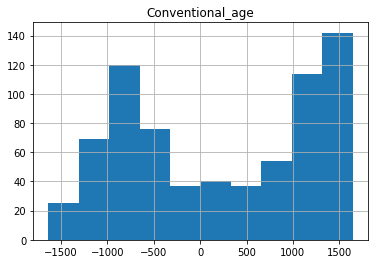

In [12]:
#Calculate conventional radiocarbon age, uncorrected for the Seuss effect, bomb carbon, or AABW ventilation

df_ages = df_matched.copy()
df_ages['Conventional_age'] = -8033 * np.log(1+0.001*(df_ages['c14']+67))
df_ages.hist(column='Conventional_age')
df_ages.to_csv(r'C:/Users/Becca/Desktop/JP/GP15/GLODAP/GP15_GLODAP_ages.csv', index=True)

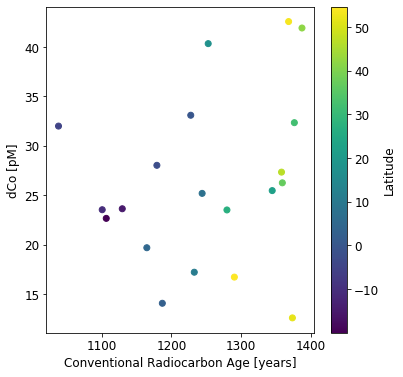

In [13]:
# dCo vs Conventional age averaged by station

df_ages_deep = df_ages[df_ages['DEPTH [m]'] > 3000]
stn_list = list(df_ages_deep['Station'].unique())
#remove station 18.3
# stn_list.remove(18.3)

dCo_average_list = []
age_average_list = []
lat_list = []
long_list = []
dCo_std_list = []
age_std_list = []

i=0
for stn in stn_list:
    df_stn = df_ages_deep[df_ages_deep['Station'] == stn_list[i]]
    dCo_average = df_stn['dCo [pM]'].mean()
    age_average = df_stn['Conventional_age'].mean()
    lat = df_stn['Latitude'].mean()
    long = df_stn['Longitude'].mean()
    dCo_std = df_stn['dCo [pM]'].std()
    age_std = df_stn['Conventional_age'].std()
    dCo_average_list.append(dCo_average)
    age_average_list.append(age_average)
    dCo_std_list.append(dCo_std)
    age_std_list.append(age_std)
    lat_list.append(lat)
    long_list.append(long)
    i=i+1

deep_means_bystn = pd.DataFrame(list(zip(stn_list, lat_list, long_list, dCo_average_list, dCo_std_list, age_average_list, 
                                      age_std_list)), 
                            columns = ['Station', 'Latitude', 'Longitude', 'dCo_mean', 'dCo_std', 'Conventional_age_mean', 
                                       'Conventional_age_std'])
                             
stn = 'Station'
lat = 'Latitude'
x = 'Conventional_age_mean'
y = 'dCo_mean'
xaxis_label = 'Conventional Radiocarbon Age [years]'
yaxis_label = 'dCo [pM]'
zaxis_label = 'Latitude'
font_size = 12
title_font_size = 14
color_scheme = 'viridis'

plt.figure(figsize=(6, 6))
fig = plt.scatter(x, y, c=lat, data=deep_means_bystn, cmap=color_scheme)
# fig = plt.errorbar(deep_means_bystn[x].values[n], df_regional_ages[y].values[n], yerr = df_regional_ages[Yerr].values[n], 
#              xerr = df_regional_ages[Xerr].values[n], fmt = 'o', capsize = 5 ,ms = marker_size,
#              label = df_regional_ages['Region'].values[n], c=colors[n])
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)
plt.show()

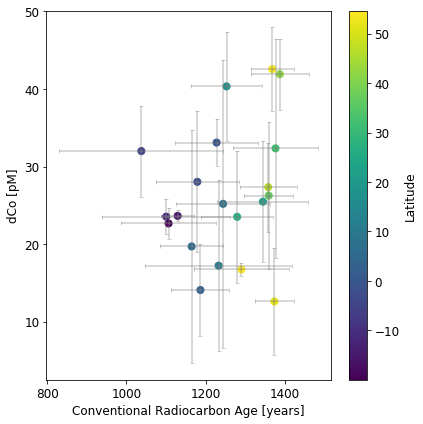

In [14]:
# dCo vs Conventional age averaged by station with error                              
stn = 'Station'
lat = 'Latitude'
x = 'Conventional_age_mean'
y = 'dCo_mean'
xaxis_label = 'Conventional Radiocarbon Age [years]'
yaxis_label = 'dCo [pM]'
zaxis_label = 'Latitude'
font_size = 12
title_font_size = 14
color_scheme = 'viridis'
marker_size = 1

Yerr = 'dCo_std'
Xerr = 'Conventional_age_std'

plt.figure(figsize=(6, 6))
for index, row in deep_means_bystn.head(n=deep_means_bystn['Station'].count()).iterrows():
    plt.errorbar(row[x], row[y], yerr = row[Yerr], xerr = row[Xerr], 
                       fmt = 'o', capsize = 2, ms = marker_size, color="gray", alpha = 0.4)
plt.scatter(x, y, c=lat, data=deep_means_bystn, cmap=color_scheme, alpha = 1, s=50)
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)
plt.tight_layout()
plt.savefig('C:/Users/Becca/Desktop/JP/GP15/GLODAP/age_bystn_witherr', dpi=300)
plt.show()

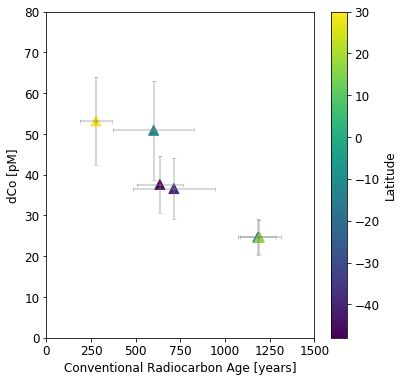

,Cruise,Latitude,Longitude,Station,D14C,D14C std,D14C n,dCo [pM],dCo std,dCo n,Conventional Age,Conventional Age std
0,GA03,30,-57,12,-101,11,288,53.2,10.8,93,277.873076,91.473085
1,GAc01,-12,-23,4,-139,26,136,50.9,12.2,37,600.254247,225.062500
2,GA10,-40,-24,14,-152,26,136,36.6,7.4,130,713.581140,228.260109
3,GIPY4,-48,4,S3,-143,15,90,37.6,7.1,11,634.954085,130.405844
4,GP16,-11,-152,36,-204,11,78,24.7,4.5,114,1183.586943,102.390498
5,GPc3,17,-154,1,-205,13,88,24.7,4.1,42,1192.900567,121.147332


In [15]:
#global data from Hawco et al 2018 (>3000 m)
cruise = ['GA03', 'GAc01', 'GA10', 'GIPY4', 'GP16', 'GPc3']
Latitude = [30, -12, -40, -48, -11, 17]
Longitude = [-57, -23, -24, 4, -152, -154]
Station = [12, 4, 14, 'S3', 36, 1]
D14C = [-101, -139, -152, -143, -204, -205]
D14C_std = [11, 26, 26, 15, 11, 13]
D14C_n = [288, 136, 136, 90, 78, 88]
dCo = [53.2, 50.9, 36.6, 37.6, 24.7, 24.7]
dCo_std = [10.8, 12.2, 7.4, 7.1, 4.5, 4.1]
dCo_n = [93, 37, 130, 11, 114, 42]

D14C_uncertainties = []
i=0
for point in D14C:
    uncertainty = ufloat(D14C[i], D14C_std[i])
    D14C_uncertainties.append(uncertainty)
    i=i+1

df_global = pd.DataFrame(list(zip(cruise, Latitude, Longitude, Station, D14C, D14C_std, D14C_n,
                                  dCo, dCo_std, dCo_n)), 
                        columns = ['Cruise', 'Latitude', 'Longitude', 'Station', 'D14C', 'D14C std', 'D14C n', 
                                   'dCo [pM]', 'dCo std', 'dCo n'])

df_global['Conventional Age'] = -8033 * np.log(1+0.001*(df_global['D14C']+67))

age_uncertainties = []
age_std = []
i=0
for point in D14C:
#     conventional_age = (D14C_uncertainties[i]+67)
    conventional_age = -8033 * log(1+0.001*(D14C_uncertainties[i]+67))
    age_uncertainties.append(conventional_age)
    std = conventional_age.s
    age_std.append(std)
    i=i+1

df_global['Conventional Age std'] = age_std

lat = 'Latitude'
x = 'Conventional Age'
y = 'dCo [pM]'
xaxis_label = 'Conventional Radiocarbon Age [years]'
yaxis_label = 'dCo [pM]'
zaxis_label = 'Latitude'
font_size = 12
title_font_size = 14
color_scheme = 'viridis'
marker_size = 1

Yerr = 'dCo std'
Xerr = 'Conventional Age std'

plt.figure(figsize=(6, 6))
for index, row in df_global.head(n=df_global['Station'].count()).iterrows():
    plt.errorbar(row[x], row[y], yerr = row[Yerr], xerr = row[Xerr], 
                       fmt = 'o', capsize = 2, ms = marker_size, color="gray", alpha = 0.4)
plt.scatter(x, y, c=lat, data=df_global, cmap=color_scheme, alpha = 1, s=100, marker = '^')
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.xlim(0,1500)
plt.ylim(0,80)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)
plt.show()

df_global

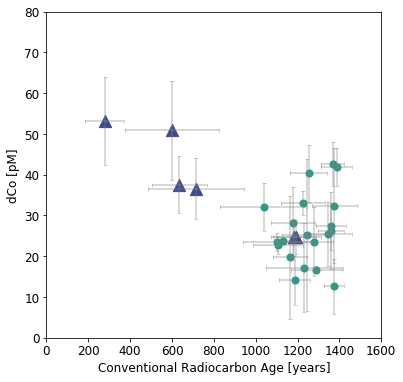

In [16]:
lat = 'Latitude'

xaxis_label = 'Conventional Radiocarbon Age [years]'
yaxis_label = 'dCo [pM]'
zaxis_label = 'Latitude'
font_size = 12
title_font_size = 14
color_scheme = 'viridis'
marker_size = 1

colors = ['#440154', '#482878', '#3e4a89', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6dcd59', '#b4de2c', '#fde725']
# colors = ['#440154', '#3e4a89', '#31688e',  '#26828e',  '#35b779', '#b4de2c', '#fde725']

Yerr = 'dCo std'
Xerr = 'Conventional Age std'

plt.figure(figsize=(6, 6))
#GP15 data
x = 'Conventional_age_mean'
y = 'dCo_mean'
Yerr = 'dCo_std'
Xerr = 'Conventional_age_std'
for index, row in deep_means_bystn.head(n=deep_means_bystn['Station'].count()).iterrows():
    plt.errorbar(row[x], row[y], yerr = row[Yerr], xerr = row[Xerr], 
                       fmt = 'o', capsize = 2, ms = marker_size, color="gray", alpha = 0.4)
plt.scatter(x, y, c=colors[5], data=deep_means_bystn, alpha = 1, s=50)
#Hawco et al 2018 data
x = 'Conventional Age'
y = 'dCo [pM]'
Yerr = 'dCo std'
Xerr = 'Conventional Age std'
i=1
for index, row in df_global.head(n=df_global['Station'].count()).iterrows():
    plt.errorbar(row[x], row[y], yerr = row[Yerr], xerr = row[Xerr], 
                       fmt = 'o', capsize = 2, ms = marker_size, color="gray", alpha = 0.4)
    plt.scatter(row[x], row[y], alpha = 1, s=150, marker = '^', c=colors[2])
    i=i+1
# plt.scatter(x, y, c=colors, data=df_global, alpha = 1, s=80, marker = "^")
#figure parameters
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.xlim(0,1600)
plt.ylim(0,80)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)
plt.show()

In [17]:
stn = 'Station'
age = 'Conventional_age'
lat = 'Latitude'
aou = 'aou'
z = 'DEPTH [m]'
Co = 'dCo [pM]'

#divide dataset by region
region_names = ['N Pac. Subpolar Gyre', 'N Pac. Subtropical Gyre', 'Equatorial Pacific', 'S Pac. Subtropical Gyre']

df_NPSPG_age = df_ages_deep[(df_ages_deep[stn] >= 4) & (df_ages_deep[stn] <= 9)]
df_NPSTG_age = df_ages_deep[(df_ages_deep[stn] >= 10) & (df_ages_deep[stn] <= 19)]
df_EP_age = df_ages_deep[(df_ages_deep[stn] >= 20) & (df_ages_deep[stn] <= 34)]
df_SPSTG_age = df_ages_deep[(df_ages_deep[stn] >= 35) & (df_ages_deep[stn] <= 39)]

#find stats for each region
regional_ages_dict = dict()
regions = [df_NPSPG_age, df_NPSTG_age, df_EP_age, df_SPSTG_age]
n=0
for regional_stats in regions:
    df = regions[n]
    count = df[z].count()
    mean_age = df[age].mean()
    mean_age_err = df[age].std()
    mean_aou = df[aou].mean()
    mean_aou_err = df[aou].std()
    mean_dCo = df[Co].mean()
    mean_dCo_err = df[Co].std()
    
    regional_ages_dict[n] = [count, mean_age, mean_age_err, mean_aou, mean_aou_err, mean_dCo, mean_dCo_err]
    n=n+1
df_regional_ages = pd.DataFrame(regional_ages_dict) 
df_regional_ages = df_regional_ages.transpose()
df_regional_ages.columns = ['n', 'mean age', 'mean age err', 'mean aou', 'mean aou err', 'mean dCo', 'mean dCo err']
df_regional_ages['Region'] = region_names 
print(df_regional_ages)

      n     mean age  mean age err    mean aou  mean aou err   mean dCo  \
0  20.0  1342.935180     85.304617  196.133941      9.913912  24.260049   
1  29.0  1339.956679     98.005349  187.440318     11.620440  31.043149   
2  32.0  1201.359228    130.646077  174.096691     13.701610  25.029987   
3  14.0  1105.926123    136.269607  158.800196     10.611546  23.372474   

   mean dCo err                   Region  
0     11.869325     N Pac. Subpolar Gyre  
1     11.108168  N Pac. Subtropical Gyre  
2     13.329422       Equatorial Pacific  
3      1.955613  S Pac. Subtropical Gyre  


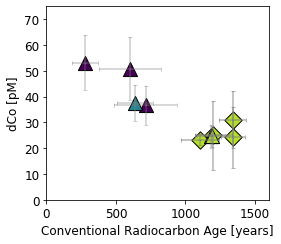

In [18]:
lat = 'Latitude'

xaxis_label = 'Conventional Radiocarbon Age [years]'
yaxis_label = 'dCo [pM]'
# zaxis_label = 'Latitude'
font_size = 12
title_font_size = 14
color_scheme = 'viridis'
marker_size = 1

colors = ['#440154', '#440154', '#440154', '#26828e', '#b4de2c', '#b4de2c', '#b4de2c', '#b4de2c', '#b4de2c']
# colors = ['#440154', '#482878', '#3e4a89', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6dcd59', '#b4de2c', '#fde725']
# colors = ['#440154', '#3e4a89', '#31688e',  '#26828e',  '#35b779', '#b4de2c', '#fde725']

labels = ['Atlantic', 'Atlantic', 'Atlantic', 'Southern Ocean', 'Pacific', 'Pacific']

Yerr = 'dCo std'
Xerr = 'Conventional Age std'

plt.figure(figsize=(4, 3.5))
#GP15 data
x = 'mean age'
y = 'mean dCo'
Yerr = 'mean dCo err'
Xerr = 'mean age err'
i=5
for index, row in df_regional_ages.head(n=df_regional_ages['n'].count()).iterrows():
    plt.errorbar(row[x], row[y], yerr = row[Yerr], xerr = row[Xerr], 
                       fmt = 'o', capsize = 2, ms = marker_size, color="gray", alpha = 0.6)
    plt.scatter(row[x], row[y], c=colors[i], data=deep_means_bystn, alpha = 1, s=150, marker = 'D', edgecolor='k', 
                label = 'Pacific GP15')
    i=i+1
#Hawco et al 2018 data
x = 'Conventional Age'
y = 'dCo [pM]'
Yerr = 'dCo std'
Xerr = 'Conventional Age std'
i=0
for index, row in df_global.head(n=df_global['Station'].count()).iterrows():
    plt.errorbar(row[x], row[y], yerr = row[Yerr], xerr = row[Xerr], 
                       fmt = 'o', capsize = 2, ms = marker_size, color="gray", alpha = 0.4)
    plt.scatter(row[x], row[y], alpha = 1, s=200, marker = '^', c=colors[i], edgecolor = 'k', label = labels[i])
    i=i+1
# #GP15 data
# x = 'mean age'
# y = 'mean dCo'
# Yerr = 'mean dCo err'
# Xerr = 'mean age err'
# i=5
# for index, row in df_regional_ages.head(n=df_regional_ages['n'].count()).iterrows():
#     plt.errorbar(row[x], row[y], yerr = row[Yerr], xerr = row[Xerr], 
#                        fmt = 'o', capsize = 2, ms = marker_size, color="gray", alpha = 0.6)
#     plt.scatter(row[x], row[y], c=colors[i], data=deep_means_bystn, alpha = 0.9, s=150, marker = 'D', edgecolor='k', 
#                 label = 'Pacific GP15')
#     i=i+1
#figure parameters
# plt.legend(fontsize = font_size, loc='best')
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.xlim(0,1600)
plt.ylim(0,75)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)
plt.tight_layout()
plt.savefig('C:/Users/Becca/Desktop/JP/GP15/GLODAP/age_bybasin_witherr', dpi=300)
plt.show()

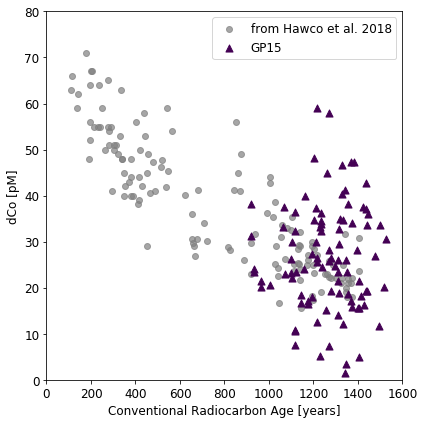

In [19]:
df_Nick = pd.read_csv('C:/Users/Becca/Desktop/JP/GP15/GLODAP/From Nick/Nicks_data_deeperthan3000m.csv')
# cruise_list = list(df_Nick['Cruise'].unique())

xaxis_label = 'Conventional Radiocarbon Age [years]'
yaxis_label = 'dCo [pM]'
font_size = 12
title_font_size = 14
color_scheme = 'viridis'
x_limit = (0,1600)
y_limit = (0,80)

plt.figure(figsize=(6, 6))
#Plot Nick's data
x = 'Conv. Natural age'
y = 'Cobalt_12_3_15'
fig = plt.scatter(x, y, c='grey', alpha = 0.7, data=df_Nick, label = 'from Hawco et al. 2018')
#Plot GP15 data
x = 'Conventional_age'
y = 'dCo [pM]'
fig = plt.scatter(x, y, c='#440154', marker = '^', s=50, data=df_ages_deep, label = 'GP15')
plt.ylim(y_limit)
plt.xlim(x_limit)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)
plt.legend(loc='best', fontsize=font_size)
plt.tight_layout()
plt.savefig('C:/Users/Becca/Desktop/JP/GP15/GLODAP/age_allpoints', dpi=300)
plt.show()

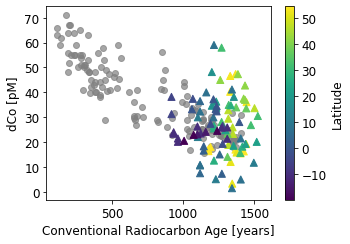

In [20]:
xaxis_label = 'Conventional Radiocarbon Age [years]'
yaxis_label = 'dCo [pM]'
zaxis_label = 'Latitude'
font_size = 12
title_font_size = 14
color_scheme = 'viridis'
x_limit = (0,1600)
y_limit = (0,80)

plt.figure(figsize=(4.85, 3.5))
#Plot Nick's data
x = 'Conv. Natural age'
y = 'Cobalt_12_3_15'
fig = plt.scatter(x, y, c='grey', alpha = 0.7, data=df_Nick, label = 'from Hawco et al. 2018')
#Plot GP15 data
x = 'Conventional_age'
y = 'dCo [pM]'
fig = plt.scatter(x, y, c='Latitude', marker = '^', s=50, cmap=color_scheme, data=df_ages_deep, label = 'GP15')
cbar = plt.colorbar()
cbar.set_label(label=zaxis_label, size=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.xlabel(xaxis_label, fontsize=font_size)
plt.ylabel(yaxis_label, fontsize=font_size)
plt.tick_params(axis='x', colors = 'black')
plt.tick_params(axis='both', which='major', labelsize=font_size)
# plt.legend(loc='best', fontsize=font_size)
plt.tight_layout()
plt.savefig('C:/Users/Becca/Desktop/JP/GP15/GLODAP/age_allpoints_bylat', dpi=300)
plt.show()

In [21]:
df_ages_deep

,index_x,Unnamed: 0,Cruise,Station,Latitude,Longitude,Sample #,Date Sampled,DEPTH [m],Stn-depth,...,tocf,doc,docf,don,donf,tdn,tdnf,chla,chlaf,Conventional_age
47,47,47,GP15,4.0,54.65985,-155.17000,12671,43372,3250,4-3250,...,9.0,35.85,2.0,-9999.0,9.0,39.77,2.0,-9999.0,9.0,1425.483366
48,48,48,GP15,4.0,54.65985,-155.17000,12669,43372,3600,4-3600,...,9.0,-9999.00,9.0,-9999.0,9.0,-9999.00,9.0,-9999.0,9.0,1403.450200
49,49,49,GP15,4.0,54.65985,-155.17000,12667,43372,4000,4-4000,...,9.0,-9999.00,9.0,-9999.0,9.0,-9999.00,9.0,-9999.0,9.0,1367.179463
50,50,50,GP15,4.0,54.65985,-155.17000,12663,43372,5000,4-5000,...,9.0,36.35,2.0,-9999.0,9.0,37.89,2.0,-9999.0,9.0,1191.968718
51,51,51,GP15,4.0,54.65985,-155.17000,12659,43372,5490,4-5490,...,9.0,-9999.00,9.0,-9999.0,9.0,-9999.00,9.0,-9999.0,9.0,1177.073825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,676,676,GP15,37.0,-14.99997,-152.00007,15567,43423,3700,37-3700,...,9.0,37.40,2.0,-9999.0,9.0,-9999.00,9.0,-9999.0,9.0,1158.493962
675,677,677,GP15,37.0,-14.99997,-152.00007,15563,43423,4620,37-4620,...,9.0,-9999.00,9.0,-9999.0,9.0,-9999.00,9.0,-9999.0,9.0,1100.246714
712,714,714,GP15,39.0,-19.99996,-152.00002,15761,43426,3400,39-3400,...,9.0,-9999.00,9.0,-9999.0,9.0,-9999.00,9.0,-9999.0,9.0,1238.694071
713,715,715,GP15,39.0,-19.99996,-152.00002,15757,43426,4060,39-4060,...,9.0,-9999.00,9.0,-9999.0,9.0,-9999.00,9.0,-9999.0,9.0,1073.575787


In [22]:
#find age ranges
print(df_ages_deep['Conventional_age'].max())
print(df_ages_deep['Conventional_age'].min())

1523.9305914063027
918.0847130482915
